# Task: Binary Prediction
Given a training set of 9,000 samples and 205 features, we must build a model to classify the dataset as best as possible. The steps for this task consist of:
1. [Data Preparation](#data_preparation)
    1. [Reading File Contents](#reading)
    2. [Imputing Missing Values](#imputing)
    3. [Selecting Features Based on Correlation](#correlation)
    4. [Selecting Features Based on P-Value](#p-value)
2. [Building the Model](#building)
    1. [Training on Data](#training)
    2. [Calculating Accuracy](#accuracy)

In [1]:
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

In [2]:
# Set random seed in order to ensure reproducibility of results
np.random.seed(123)

<a id='data_preparation'></a>
## Data Preparation
This includes reading file contents, imputing missing values, and feature selection.

<a id='reading'></a>
### Reading file contents
We are given two files:
- attr.txt, which consists of features (attributes), their ranges, and whether they are discrete(categorical) or continuous(numerical)
- data.txt, which consists of labelled samples

In [3]:
# Checks whether the feature is discrete(categorical) or continuous(numerical)
# If a feature name begins with "C" it is continuous, and if it begins with "D" it is discrete
def attr_type(attr_name):
    return attr_name[0]

In [4]:
# Read in file paths and define variables to store file data
attr_file_path = 'attr.txt'
training_file_path = 'data.txt'
attr_names = []
train_dict = dict()

In [5]:
# Read in features
with open(attr_file_path) as f:
    for line in f:
        line_wo_space = line.translate({ord(c): None for c in string.whitespace})
        if line_wo_space != '':
            attr_name = line_wo_space.split(':')[0]
            attr_names.append(attr_name)
            train_dict[attr_name] = list()

In [6]:
# Read in samples
with open(training_file_path) as f:
    for line in f:
        if line.translate({ord(c): None for c in string.whitespace}) != '':
            instance_attr = line.split()
            for attr_index in range(len(attr_names)):
                if instance_attr[attr_index] == '?':
                    train_dict[attr_names[attr_index]].append(None)
                elif attr_type(attr_names[attr_index]) == 'C':
                    train_dict[attr_names[attr_index]].append(float(instance_attr[attr_index]))
                else:
                    train_dict[attr_names[attr_index]].append(int(instance_attr[attr_index]))
data = pd.DataFrame(train_dict)
data.head()

,C1,C2,D1,C3,C4,D2,D3,D4,D5,D6,...,C143,C144,C145,C146,C147,C148,C149,C150,C151,class
0,2002.0,79.0,4.0,40.9431,-74.0035,0.0,1.0,1.0,0.0,0.0,...,2.0,2.0,1.0,1.0,1.0,2.0,1.0,3.0,3.0,0
1,2004.0,105.0,4.0,39.8810,-74.9721,0.0,1.0,1.0,0.0,0.0,...,2.0,2.0,1.0,1.0,1.0,2.0,1.0,3.0,3.0,0
2,1999.0,48.0,2.0,40.6725,-73.7503,1.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,1.0,1.0,2.0,1.0,3.0,3.0,0
3,1996.0,9.0,2.0,42.1694,-70.9469,0.0,1.0,0.0,0.0,0.0,...,2.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,4.0,0
4,1994.0,78.0,2.0,38.7379,-76.6517,0.0,1.0,0.0,0.0,0.0,...,2.0,2.0,1.0,1.0,1.0,2.0,1.0,4.0,4.0,1


<a id='imputing'></a>
### Imputing Missing Values
We use a SimpleImputer from sklearn to impute average (mean) values for numerical features and most frequent (mode) values for categorical features.

In [7]:
# Split the dataset into numerical and categorical features
numF, catF = list(), list()
for f in data.columns:
    if attr_type(f) == "C":
        numF.append(f)
    elif attr_type(f) == "D":
        catF.append(f)

num_df = data[numF]
cat_df = data[catF]
labels = data['class']

In [8]:
# Impute missing numerical feature values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
num_df = pd.DataFrame(imputer.fit_transform(num_df))
num_df.columns = numF

# Impute missing categorical feature values
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cat_df = pd.DataFrame(imputer.fit_transform(cat_df))
cat_df.columns = catF

# Join inputed data tables to recreate data with inputed values
data = pd.concat([num_df, cat_df, data['class']], axis=1, join='inner')
data.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,D46,D47,D48,D49,D50,D51,D52,D53,D54,class
0,2002.0,79.0,40.9431,-74.0035,1.0,2.0,2.0,1.0,2.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2004.0,105.0,39.8810,-74.9721,2.0,3.0,2.0,2.0,2.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1999.0,48.0,40.6725,-73.7503,2.0,1.0,2.0,1.0,2.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1996.0,9.0,42.1694,-70.9469,3.0,3.0,4.0,4.0,3.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1994.0,78.0,38.7379,-76.6517,4.0,4.0,4.0,4.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


<a id='correlation'></a>
### Selecting Features Based on Correlation
We visualize the correlation between features, then remove one of two features that have high correlation. Once we have made our selections, we print how many features remain.

<AxesSubplot:>

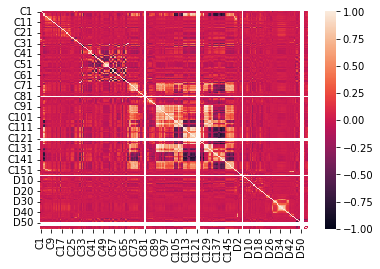

In [9]:
# Generate a heatmap of the correlation matrix of features
corr = data.corr()
sns.heatmap(corr)

In [10]:
# Next, we compare the correlation between features and remove one of two features that have a correlation greater than 0.95
num_features = corr.shape[0]
columns = np.full((num_features,), True, dtype=bool)
corr_thresh = 0.95
for i in range(num_features):
    for j in range(i+1, num_features):
        if corr.iloc[i,j] > corr_thresh:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
# Print the number of features selected
print(selected_columns.shape)
# Narrow the dataset to the features selected
data = data[selected_columns]

(193,)


<a id='p-value'></a>
### Selecting Columns Based on P-Value
We remove features above a certain p-value, as that indicates that the feature does not have enough correlation with the sample class (label). Once we have made our selections, we print how many features remain.

In [11]:
# Removing the class column
selected_columns = selected_columns[:-1].values
# Create a function to remove features with p-value greater than a given constant threshold
def backwardElimination(x, Y, sl, columns):
    num_features = len(x[0])
    for i in range(num_features):
        regressor_OLS = sm.OLS(Y, x).fit()
        max_feature = max(regressor_OLS.pvalues).astype(float)
        if max_feature > sl:
            for j in range(num_features - i):
                if (regressor_OLS.pvalues[j].astype(float) == max_feature):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
    return x, columns
# Run the function to remove features with p-value greater than 0.075
SL = 0.075
data_modeled, selected_columns = backwardElimination(data.iloc[:,:-1].values, data.iloc[:,-1].values, SL, selected_columns)
# Print the number of columns selected
print(selected_columns.shape)
# Moving the result to a new dataframe
labels = np.array(data['class'])
# Creating a dataframe with the columns selected using the p-value and correlation
data = pd.DataFrame(data = data_modeled, columns = selected_columns)

(79,)


<a id='building'></a>
## Building the Model
We now build a predictive model using the features we selected in the previous steps. This involves both training the model and verifying that it functions properly using a test set. Before we begin, we must split the dataset into a train set and test set.

In [12]:
# Split the data into training and testing sets
data = np.array(data)
train_features, test_features, train_labels, test_labels = train_test_split(data, labels, test_size = 0.20)

<a id='training'></a>
### Training on Data
We train a Random Forest classifier with the train set.

In [13]:
# Set random state in order to ensure reproducibility of results
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(train_features, train_labels)

RandomForestRegressor(random_state=42)

<a id='accuracy'></a>
### Calculating Accuracy
To calculate accuracy, we predict the labels for samples in the test set. Then, we calculate the percentage of labels predicted corrected.

In [14]:
# Use the classifier's predict method on the test data
predictions = rf.predict(test_features)
predictions = np.round(predictions)
# Calculate the absolute errors
errors = 1.0 - abs(predictions - test_labels)
# Print out the mean absolute error
print('Accuracy:', str('{:.4f}'.format(round(np.mean(errors), 4))))

Accuracy: 0.7739
